# 二维数据的 DFT  处理

DFT 计算分为 CPU 和 GPU 实现的两种版本：
- CPU 处理的版本无法处理过大的图像，当图像过大时，处理时间会过长。
- GPU 加速处理的版本可以处理任意大小的图像，这是分块计算出各个点的 DFT 级数和。块的大小不能过大，否则会出现内存分配失败的情况。

In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np

cuda = drv
numpy = np
from pycuda.compiler import SourceModule
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [3, 2]
mpl.rcParams['figure.dpi'] = 1
# print(mpl.rcParams['figure.figsize'])
# print(mpl.rcParams['figure.dpi'])
%matplotlib inline
import math
PI2 = math.pi * 2
from tqdm import tqdm, tnrange

### 读取图片

使用 matplotlib 读取图片，并简化绘图操作

In [2]:
def plti(im, **kwargs):
    y = im.shape[0]
    x = im.shape[1]
    w = y / x * h
#     fig=plt.figure(dpi=dpi)
#     ax.plot(im, **kwargs)
#     plt.figure(figsize=(w, h))
    plt.imshow(im, interpolation='none', **kwargs)
    plt.axis('off')
    plt.show()

In [3]:
def to_greyscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    tile = np.tile(weights, reps=(im.shape[0], im.shape[1], 1))
    return np.sum(tile * im, axis = 2)

In [4]:
image = plt.imread("IMG_MIN.jpg")
h, w, d = image.shape
# plt.rcParams['figure.dpi'] = 1.0

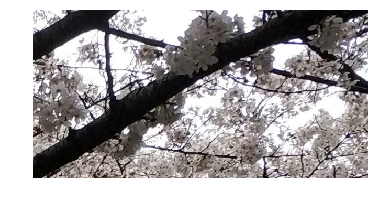

(320, 640, 3)


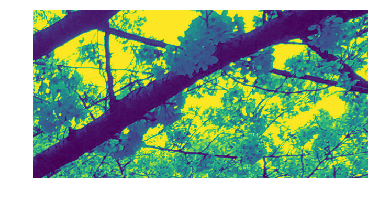

In [5]:
plti(image)
print(image.shape)
grey_img = to_greyscale(image)
plti(grey_img)

In [6]:
plt.imsave("grey.png", grey_img)

## GPU ACCELERATED DFT

### GPU 代码：

In [7]:
mod = SourceModule("""
#include <cuComplex.h>
#include <math_constants.h>

struct DoubleOperation {
    int M, N; // so 64-bit ptrs can be aligned
    int u, v;
    float *ptr;
    float *Fr;
    float *Fi;
};


__global__ void double_array(DoubleOperation *a) {
    a = &a[blockIdx.x + blockIdx.y * a->M];
    // test = &test[blockIdx.x];
    for (int y = threadIdx.y; y < a->N; y += blockDim.y) {
        for (int x = threadIdx.x; x < a->M; x += blockDim.x) {
            int idx = x + y * a->M;
            float t = - CUDART_PI_F * 2 * (float(a->u * x) / a->M + float(a->v * y) / a->N);
            a->Fr[idx] = a->ptr[idx] * cosf(t);
            a->Fi[idx] = a->ptr[idx] * sinf(t);
        }
    }
}
""")

`DFTOpStruct` 对象用于和 GPU 交换数据。

In [8]:
class DFTOpStruct:
    mem_size = 16 + np.intp(0).nbytes * 3
    _data = None
    def __init__(self, array, struct_arr_ptr, u = 0, v = 0):
#         self.data = cuda.to_device(array)
        test = np.zeros_like(array, dtype=np.float32)
        self.Fr = cuda.to_device(test)
        self.shape, self.dtype = array.shape, array.dtype
        test2 = np.zeros_like(array, dtype=np.float32)
        self.Fi = cuda.to_device(test2)
        self.shape, self.dtype = array.shape, array.dtype
        
        cuda.memcpy_htod(int(struct_arr_ptr),     memoryview(np.int32(array.shape[1]))) # Operation int
        cuda.memcpy_htod(int(struct_arr_ptr) + 4, memoryview(np.int32(array.shape[0]))) # Operation int
        cuda.memcpy_htod(int(struct_arr_ptr) + 8,  memoryview(np.int32(u))) # Operation int
        cuda.memcpy_htod(int(struct_arr_ptr) + 12, memoryview(np.int32(v))) # Operation int
        cuda.memcpy_htod(int(struct_arr_ptr) + 16, memoryview(np.intp(int(self._data)))) # DoubleOperation ptr
        cuda.memcpy_htod(int(struct_arr_ptr) + 16+ np.intp(0).nbytes , memoryview(np.intp(int(self.Fr))))
        cuda.memcpy_htod(int(struct_arr_ptr) + 16+ np.intp(0).nbytes * 2, memoryview(np.intp(int(self.Fi))))
        
#         print(np.int32(array.shape[1]), np.int32(array.shape[0]))
        
    def __str__(self):
        return str(cuda.from_device(self._data, self.shape, self.dtype))
    
    def getFr(self):
        return np.array(cuda.from_device(self.Fr, self.shape, self.dtype))
    def getFi(self):
        return np.array(cuda.from_device(self.Fi, self.shape, self.dtype))
    
    def print_test(self):
        print(str(cuda.from_device(self.Fr, self.shape, self.dtype)))
    
    def print_test2(self):
        print(str(cuda.from_device(self.Fi, self.shape, self.dtype)))

subCalcDFT 将输入的图像分块计算 DFT 结果，col 是块的列数，row 是块的行数，块的大小不宜太大

In [9]:
func = mod.get_function("double_array")

def subCalcDFT(img, us = 0, col = 16, vs = 0, row = 16):
    """
    us: start of u
    vs: start of v
    col: range of u
    """
    img = img.astype(np.float32)
    batch_size = row * col
    struct_arr = cuda.mem_alloc(batch_size * DFTOpStruct.mem_size) # 分配内存
    ptr = [int(struct_arr) + DFTOpStruct.mem_size * i for i in range(batch_size)]
    arr = []
    DFTOpStruct._data = cuda.to_device(img)
#     for u in tnrange(us, us + col, desc="Memory Alloacte"):
    for u in range(us, us + col):        
        for v in range(vs, vs + row):
            idx = u - us + (v - vs) * col
            o = DFTOpStruct(img, ptr[idx], u = u, v = v)
            arr.append(o)
    func(struct_arr, block = (row, col, 1), grid=(1, 1))

    F = np.zeros((row, col), dtype=np.complex)
#     for u in tnrange(row, desc = "calc DFT"):
    for u in range(row):
        for v in range(col):
            i = u + v * row
            Fr = np.sum(arr[i].getFr())
            Fi = np.sum(arr[i].getFi())
            F[v][u] = Fr + 1j * Fi
    return F   

`calcDFT` 是将整幅图片全部放到 GPU 中进行计算，一般不会出现内存分配失败的情况

In [10]:
def calcDFT(img):
    img = img.astyep(np.float32)
    M = img.shape[1]
    N = img.shape[0]
    struct_arr = cuda.mem_alloc(M * N * DFTOpStruct.mem_size) # 分配内存
    ptr = [int(struct_arr) + DFTOpStruct.mem_size * i for i in range(M * N)]
#     img = np.arange(M * N, dtype=np.float32).reshape(M, N)
    arr = []
    DFTOpStruct._data = cuda.to_device(img)
    for u in tnrange(M, desc="Memory Alloacte"):
        for v in range(N):
            idx = u + v * M
            o = DFTOpStruct(img, ptr[idx], u = u, v = v)
            arr.append(o)
    func(struct_arr, block = (32, 32, 1), grid=(2, 1))

    F = np.zeros((M, N), dtype=np.complex)
    for u in tnrange(M, desc = "calc DFT"):
        for v in range(N):
            i = u + v * M
            Fr = np.sum(arr[i].getFr())
            Fi = np.sum(arr[i].getFi())
            F[v][u] = Fr + 1j * Fi
    return F

In [11]:
transed_img = np.zeros_like(grey_img, dtype=np.complex)
r = 32
c = 32
width = 288
height = 288
for y in tnrange(int(width / c), desc = "Y"):
    for x in tnrange(int(height / r), desc="X"):
        t_img = subCalcDFT(grey_img, us=x * c, col = c, vs = y * r, row = r)
        transed_img[y * r:(y+1) * r, x * c:(x+1)* c] = t_img

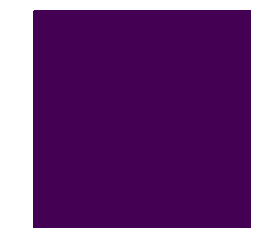

In [12]:
gpu_timg = abs(transed_img)
plti(gpu_timg[:height,:width])

In [13]:
plt.imsave("gpu_partial_grey.png", gpu_timg)
# print(gpu_timg)

## CPU DFT calculation

In [14]:
def calc(f, u, v):
    value = 0
    Ny = f.shape[0]
    Nx = f.shape[1]
    for ny in range(Ny):
        for nx in range(Nx):
            value += f[ny][nx] * np.exp(-1j * PI2* (nx/ Nx * u + ny/ Ny * v ))
#              * np.exp(-PI2 * ky * ny / Ny)
    return value

def dft(img):
    trans_img = np.zeros(img.shape, dtype=np.complex)
    height = img.shape[0]
    width = img.shape[1]
    for h in tnrange(height, desc="Height Loop"):
        for w in range(width):
            trans_img[h][w] = calc(img, w, h)
        
    return trans_img


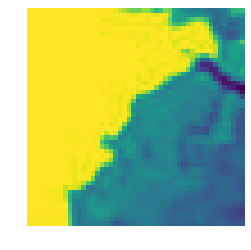

In [15]:
xoff = 280
yoff = 0
size = 48
min_grey_img = grey_img[yoff:yoff+size, xoff:xoff+size]
plti(min_grey_img)

In [16]:
plt.imsave("partial_grey.png", min_grey_img)
# print(min_grey_img, min_grey_img.shape)

In [17]:
transed_img = dft(min_grey_img)

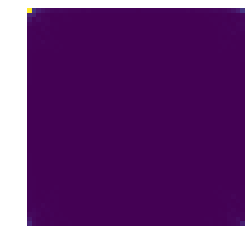

In [18]:
plti(abs(transed_img))

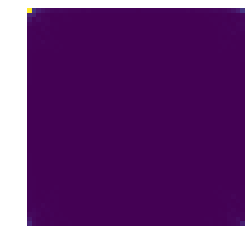

In [19]:
abs_transed_img = abs(transed_img)
np.argmax(abs_transed_img)
abs_transed_img = abs_transed_img / abs_transed_img[0][0]
plti(abs_transed_img)

In [20]:
def idft(F):
    f = np.zeros(F.shape, dtype=np.complex)
    N = F.shape[0]
    M = F.shape[1]
    for h in tnrange(N, desc="Height Loop"):
        for w in tnrange(M, desc = "Width Loop"):
            f[h][w] = icalc(F, w, h)
        
    return f
def icalc(F, x, y):
    N = F.shape[0]
    M = F.shape[1]
    value = 0
    for v in range(N):
        for u in range(M):
            value += F[v][u] * np.exp(1j * PI2 * (u/M *x + v/N *y))
            
    return value / M / N

In [21]:
test = idft(transed_img)

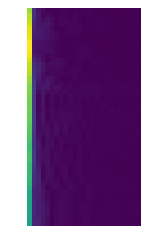

In [22]:
npfft_result = np.fft.rfft(min_grey_img)

plti(abs(npfft_result))

可以看到，GPU （ZOTAC 1070）加速后计算速度比 CPU 的计算速度快了很多。 CUDA 里面已经提供了一个 FFT 模块用于计算序列的傅里叶变换，相信用这个模块来计算会快更多。

## Reference

1. [图像处理之_傅立叶变换](https://www.jianshu.com/p/9e786be6dccb)
2. [opencv 图片的离散傅里叶变换DFT](https://blog.csdn.net/ab0902cd/article/details/51671058)
3. [PyCUDA Documentation](https://documen.tician.de/pycuda/)